In [90]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Input

Loading the data:

In [91]:
ts_data = pd.read_csv('/Users/kashyapava/Desktop/UIUC/SEM_4/STAT 430/Project 2/proj2_data_clean.csv',index_col='date', parse_dates=True)
ts_data.head(5)

,time,DOY,SWin,SWout,LWin,LWout,Rr,Rn,RH,PPFD,...,(z-d)/L,T*,v_var,w/co2_cov,w/h2o_cov,w/ch4_cov,FCH4,Ta,Tc,datetime
date,,,,,,,,,,,,,,,,,,,,,
2023-05-11,15:00,131.6249,695.4,135.20,398.9,507.4,0.194,451.60,35.8238,1340.0,...,-0.104409,-0.343706,1.337320,-0.004358,2.03306,-0.000042,-0.002199,300.282,308.48,2023-05-11 15:00:00
2023-05-11,15:30,131.6457,506.8,96.70,392.3,497.4,0.187,305.10,35.3730,982.0,...,-0.170200,-0.443938,1.958010,-0.006526,2.25563,-0.000043,0.002734,300.194,306.58,2023-05-11 15:30:00
2023-05-11,16:00,131.6665,319.4,60.97,395.8,477.3,0.190,177.00,35.6585,622.6,...,-0.099141,-0.290778,2.165070,-0.004225,1.91322,-0.000033,-0.000904,299.926,303.04,2023-05-11 16:00:00
2023-05-11,16:30,131.6873,338.2,64.57,382.2,474.9,0.188,181.00,35.4072,632.8,...,-0.060258,-0.178902,1.145780,-0.001495,1.65756,-0.000024,-0.002743,300.065,302.43,2023-05-11 16:30:00
2023-05-11,17:00,131.7082,121.5,22.22,377.4,456.5,0.184,20.15,36.9236,244.3,...,-0.060537,-0.161396,0.638123,-0.001278,1.20892,-0.000020,-0.002318,299.410,299.08,2023-05-11 17:00:00


In [92]:
# Exclude non-numeric predictors
ts_data_numeric = ts_data.select_dtypes(include=['float64', 'int64'])
ts_data_numeric.head(5)

,DOY,SWin,SWout,LWin,LWout,Rr,Rn,RH,PPFD,PPFDr,...,ET,(z-d)/L,T*,v_var,w/co2_cov,w/h2o_cov,w/ch4_cov,FCH4,Ta,Tc
date,,,,,,,,,,,,,,,,,,,,,
2023-05-11,131.6249,695.4,135.20,398.9,507.4,0.194,451.60,35.8238,1340.0,160.80,...,0.159395,-0.104409,-0.343706,1.337320,-0.004358,2.03306,-0.000042,-0.002199,300.282,308.48
2023-05-11,131.6457,506.8,96.70,392.3,497.4,0.187,305.10,35.3730,982.0,118.10,...,0.178391,-0.170200,-0.443938,1.958010,-0.006526,2.25563,-0.000043,0.002734,300.194,306.58
2023-05-11,131.6665,319.4,60.97,395.8,477.3,0.190,177.00,35.6585,622.6,74.94,...,0.147962,-0.099141,-0.290778,2.165070,-0.004225,1.91322,-0.000033,-0.000904,299.926,303.04
2023-05-11,131.6873,338.2,64.57,382.2,474.9,0.188,181.00,35.4072,632.8,76.32,...,0.125538,-0.060258,-0.178902,1.145780,-0.001495,1.65756,-0.000024,-0.002743,300.065,302.43
2023-05-11,131.7082,121.5,22.22,377.4,456.5,0.184,20.15,36.9236,244.3,29.03,...,0.093371,-0.060537,-0.161396,0.638123,-0.001278,1.20892,-0.000020,-0.002318,299.410,299.08


Transforming the data:

In [93]:
# Split into features and target
X = ts_data_numeric.drop(columns=['FCH4'])
y = ts_data_numeric['FCH4']

# Scaling data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

Train Test Split:

In [94]:
# Chronological Splitting
train_size = int(len(X_scaled) * 0.7)
val_size = int(len(X_scaled) * 0.2)

X_train, X_val, X_test = X_scaled[:train_size], X_scaled[train_size:train_size+val_size], X_scaled[train_size+val_size:]
y_train, y_val, y_test = y_scaled[:train_size], y_scaled[train_size:train_size+val_size], y_scaled[train_size+val_size:]

In [95]:
# Function to evaluate model
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

1-step ahead Forecasting using FC, RNN, and LSTM:

In [96]:
# Fully Connected Feed Forward Networks

# Fully Connected Networks
model_fc1 = Sequential([Input(shape=(X_train.shape[1],)), Dense(13, activation='relu'), Dense(1)])
model_fc1.compile(optimizer='adam', loss='mse')
model_fc1.fit(X_train, y_train, epochs=100, batch_size=13, validation_data=(X_val, y_val), verbose=0)

model_fc2 = Sequential([Input(shape=(X_train.shape[1],)), Dense(26, activation='relu'), Dense(13, activation='relu'), Dense(1)])
model_fc2.compile(optimizer='adam', loss='mse')
model_fc2.fit(X_train, y_train, epochs=100, batch_size=13, validation_data=(X_val, y_val), verbose=0)

In [97]:
# Simple RNN
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_rnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model_rnn1 = Sequential([Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])), SimpleRNN(13, activation='relu'), Dense(1)])
model_rnn1.compile(optimizer='adam', loss='mse')
model_rnn1.fit(X_train_rnn, y_train, epochs=100, validation_data=(X_val_rnn, y_val), verbose=0)

model_rnn2 = Sequential([Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])), SimpleRNN(26, activation='relu'), Dense(13, activation='relu'), Dense(1)])
model_rnn2.compile(optimizer='adam', loss='mse')
model_rnn2.fit(X_train_rnn, y_train, epochs=100, validation_data=(X_val_rnn, y_val), verbose=0)

In [98]:
# LSTM Models

# LSTM Model 1
model_lstm1 = Sequential([Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])), LSTM(13, activation='relu'), Dense(1)])
model_lstm1.compile(optimizer='adam', loss='mse')
model_lstm1.fit(X_train_rnn, y_train, epochs=100, validation_data=(X_val_rnn, y_val), verbose=0)

# LSTM Model 2
model_lstm2 = Sequential([Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])), LSTM(26, activation='relu'), Dense(13, activation='relu'), Dense(1)])
model_lstm2.compile(optimizer='adam', loss='mse')
model_lstm2.fit(X_train_rnn, y_train, epochs=100, validation_data=(X_val_rnn, y_val), verbose=0)

Results of 1 step forecasting:

In [99]:
# Predictions and Evaluations
results_1step = []
for name, model, data in zip(
    ['FC1', 'FC2', 'RNN1', 'RNN2', 'LSTM1', 'LSTM2'],
    [model_fc1, model_fc2, model_rnn1, model_rnn2, model_lstm1, model_lstm2],
    [X_test, X_test, X_test_rnn, X_test_rnn, X_test_rnn, X_test_rnn]
):
    y_pred = model.predict(data)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)
    metrics = evaluate_model(y_test_inv, y_pred_inv)
    metrics['Model'] = name
    results_1step.append(metrics)

results_1step_df = pd.DataFrame(results_1step)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [100]:
# Results
print('1-step Forecasting Results: ', '\n',results_1step_df)

1-step Forecasting Results:  
        RMSE       MSE       MAE       MAPE        R2  Model
0  0.019960  0.000398  0.014184  27.708138  0.493350    FC1
1  0.013538  0.000183  0.008717  20.519416  0.766932    FC2
2  0.012727  0.000162  0.007037  19.512214  0.794026   RNN1
3  0.020402  0.000416  0.015443  31.038780  0.470692   RNN2
4  0.013135  0.000173  0.007744  17.284792  0.780600  LSTM1
5  0.015197  0.000231  0.011483  37.050678  0.706306  LSTM2


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


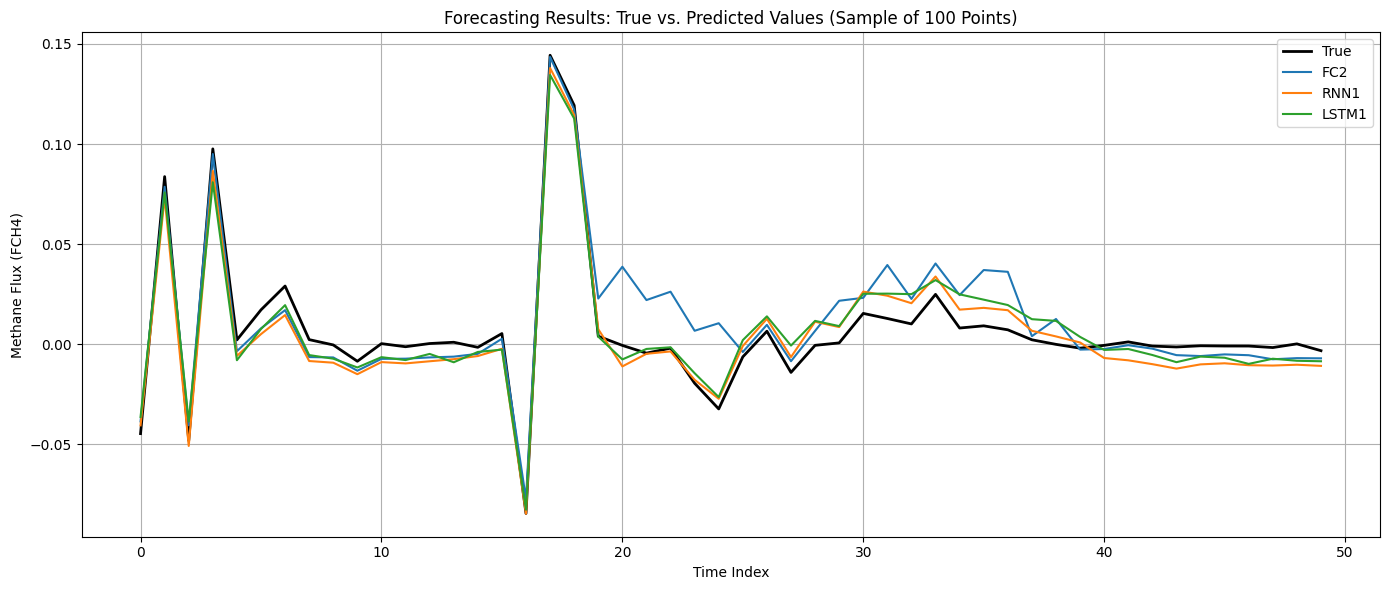

In [104]:
import matplotlib.pyplot as plt

# Number of points to plot
n_points = 50

# True values (same for all models)
y_true_sample = y_test_inv[:n_points].flatten()

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_true_sample, label='True', linewidth=2, color='black')

# Plot predicted values for each model
for name, model, data in zip(
    ['FC2', 'RNN1', 'LSTM1'],
    [model_fc1, model_fc2, model_rnn1, model_rnn2, model_lstm1, model_lstm2],
    [X_test, X_test, X_test_rnn, X_test_rnn, X_test_rnn, X_test_rnn]
):
    y_pred = model.predict(data)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    plt.plot(y_pred_inv[:n_points], label=name)

plt.title('Forecasting Results: True vs. Predicted Values (Sample of 100 Points)')
plt.xlabel('Time Index')
plt.ylabel('Methane Flux (FCH4)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Overall, the LSTM model performed better than the fully connected network and the recurrent neural network based on the evaluation metrics (RMSE, MSE, MAE, MAPE, and R-sqaured).

The RNN (Recurrent Neural Network) performed better than the FC (Fully Connected network) which can imply that the recurrent connection enables it to better capture the temporal dependencies of the data as desired from the architectural intuition of the RNN.

The LSTM (Long Short Term Memory) performed better than the RNN (Recurrent Neural Network) which can imply that the forget gate is able to exclude the unnecessary information enabling it to better capture the temporal dependency by there by solving the issue of the vanishing/ exploding gradients in RNN over a long period of time.

Note that these inferences can be viable as the same architectural parameters (number of units) were used for comparing these models.